# Motion correction

In this tutorial, we will explore the problem of drift registration, i.e. how motion correction algorithms have been applied to extracellular recordings, and how we can use them in SpikeInterface

## What are the drifts?

The layout of HD probes for in vivo applications usually consists of a long shank (e.g., ∼1 mm for Neuropixels 1.0) to allow the electrodes to span multiple regions of the brain and reach deep structures. Due to the different mechanical properties of the probe and the brain tissue, it is very common to observe a relative movement of the tissue with respect to the probe. This phenomenon is known as drift. The origins and types of such drifts can be diverse. For example, cells are likely to slowly drift from initial positions because of the pressure release in the tissue after an acute probe insertion; abrupt and discontinuous drift events could be caused by sudden rig instabilities and movement artifacts. When a neuron moves with respect to the recording electrodes, its waveforms are distorted (Fig. 1A), challenging the operation of spike sorting algorithms which mainly rely on waveform similarities to cluster different neurons in the recordings.

![alternative text](drift.png)

## How can we deal with them ?

![alternative text](drift2.png)

## What do all the methods have in common?

![alternative text](drift3.png)

## What is implemented in SpikeInterface ?
See [Garcia et al, 2024](https://doi.org/10.1523/ENEURO.0229-23.2023) for more details


![alternative text](drift4.png)

## When should we use such methods?

As one can notice, these methods are only designed for high-density probes, with enough channels. Because one needs to interpolate new traces, this methodology can only work if the density of the channels is high-enough. Moreover, these methods are currently only restricted to 1D motion along the depth, thus this is also not suited for plannar arrays.

## Case study: motion estimation and correction on a 1min long recording with rigid sinusoidal drift

We can generate artificial data via spikeinterface, using the generate_drifting_recording() function. This function returns a drifting recording, its static equivalent, and the sorting used while generating the spikes. 

In [1]:
import spikeinterface.full as si
from pathlib import Path

Let's start with a classical zigzag motion, starting at t=10s, with a period of 50s. In order to not take too much time, we will restrict ourselves to a 2min long recording, and the motion is first considered as rigid. 

In [2]:
zigzag_rigid = [{'drift_mode': 'zigzag', 
              'non_rigid_gradient': None, 
              't_start_drift': 10.0, 
              't_end_drift': None, 
              'period_s': 50}]

static, drifting, sorting = si.generate_drifting_recording(probe_name='Neuropixel-128', 
                                                        seed=23, 
                                                        duration=120, 
                                                        generate_displacement_vector_kwargs={'motion_list' : zigzag_rigid})

The default value for the drifting recording is a cropped version of a Neuropixel 2.0 layout, restricted to 128 channels

In [3]:
print(static)

InjectDriftingTemplatesRecording: 128 channels - 30.0kHz - 1 segments - 3,600,000 samples 
                                  120.00s (2.00 minutes) - float32 dtype - 1.72 GiB


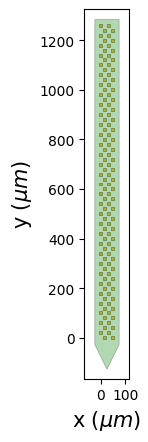

In [4]:
si.plot_probe_map(static)

Now that we are preprocessing expert, we performed all the needed steps as a simple algorithmic pipelines, that will be executed on-the-fly

In [5]:
drifting_preprocessed = si.highpass_filter(drifting)
drifting_preprocessed = si.common_reference(drifting_preprocessed, reference='global')

First, one can get a sense of possible drifts in the recordings by looking at a so-called "positional raster plot", i.e. the depth of the spike as function of time. To do so, we need to detect the peaks, and then to localize them in space using the method of our choice.

In [6]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
job_kwargs = dict(n_jobs=0.8, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(drifting_preprocessed,  
                     method='locally_exclusive',
                     detect_threshold=5, 
                     exclude_sweep_ms=2, 
                     radius_um=50., 
                     **job_kwargs)

detect peaks using locally_exclusive:   0%|          | 0/120 [00:00<?, ?it/s]

Let's localize the peaks to get a sense of their putative depths. Several localization methods are available, let's use all the methods to compare. We have:
- center_of_mass (a barycenter)
- monopolar (a biophysical approximation assuming cells are behaving as monopoles)
- grid_convolution (similar to Kilosort)

In [7]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
peak_locations = {}
for method in ['monopolar_triangulation', 'grid_convolution', 'center_of_mass']:
    peak_locations[method] = localize_peaks(drifting_preprocessed, 
                                            peaks, 
                                            method=method, 
                                            **job_kwargs)

localize peaks using monopolar_triangulation:   0%|          | 0/120 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/120 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/120 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/120 [00:00<?, ?it/s]

We can now display the positional raster plots, for all the aformentionned methods. 

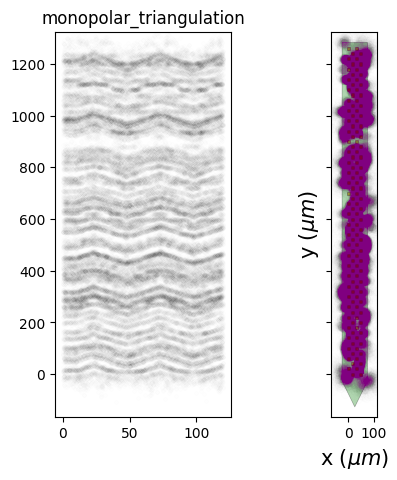

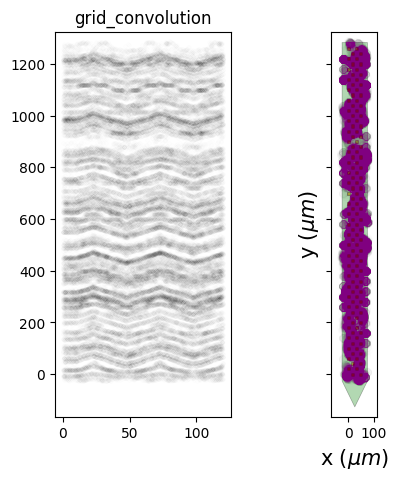

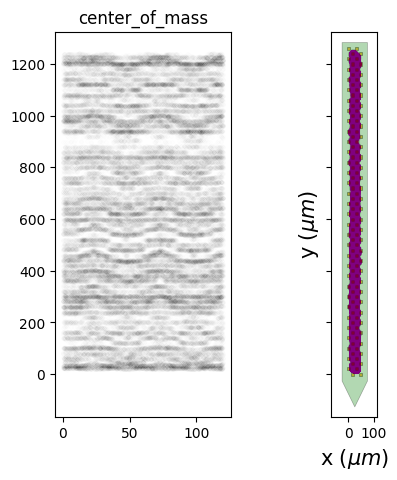

In [8]:
import pylab as plt
fs = drifting_preprocessed.sampling_frequency
for method, all_peaks in peak_locations.items():
    fig, ax = plt.subplots(ncols=2, 
                           squeeze=False, 
                           figsize=(5, 5), 
                           sharey=True)
    ax[0, 0].scatter(peaks['sample_index'] / fs, 
                     all_peaks['y'], 
                     color='k', 
                     marker='.',  
                     alpha=0.002)
    ax[0, 0].set_title(method)
    si.plot_probe_map(drifting_preprocessed, ax=ax[0, 1])
    ax[0, 1].scatter(all_peaks['x'], 
                     all_peaks['y'], 
                     color='purple', alpha=0.002)


## Motion estimation

Now, we have all the ingredients to estimate the motion in this recording. Motion estimation is a complex pre-processing step, as it requires to detect peaks, estimate motion, and then compensate for the motion. As shown in previous figures, all these steps have various possibilities. This is why SpikeInterface offers a high-level correct_motion() function with some custom presets, to let you decide what you want to do.
Among these presets, we have:
- kilosort_like: detect peaks, then localize via grid_convolution, then estimate the motion via a template approach before interpolating via kriging
- nonrigid_accurate: detect peaks, then localize via monopolar_approximation (slow but more accurate), then estimate the motion via a decentralized approach before interpolating via kriging
- nonrigid_fast_and_accurate: detect peaks, then localize via grid_convolution, then estimate the motion via a decentralized approach before interpolating via kriging

Since the recording is not too long, let's try all methods to compare

In [9]:
motions_corrected = {}
for method in ['kilosort_like', 'nonrigid_accurate', 'nonrigid_fast_and_accurate']:
    motions_corrected[method] = si.correct_motion(drifting_preprocessed, 
                                                  preset=method, 
                                                  interpolate_motion_kwargs={'border_mode' : 'force_extrapolate'},
                                                  folder=method, 
                                                  **job_kwargs)

detect and localize:   0%|          | 0/120 [00:00<?, ?it/s]

detect and localize:   0%|          | 0/120 [00:00<?, ?it/s]

detect and localize:   0%|          | 0/120 [00:00<?, ?it/s]

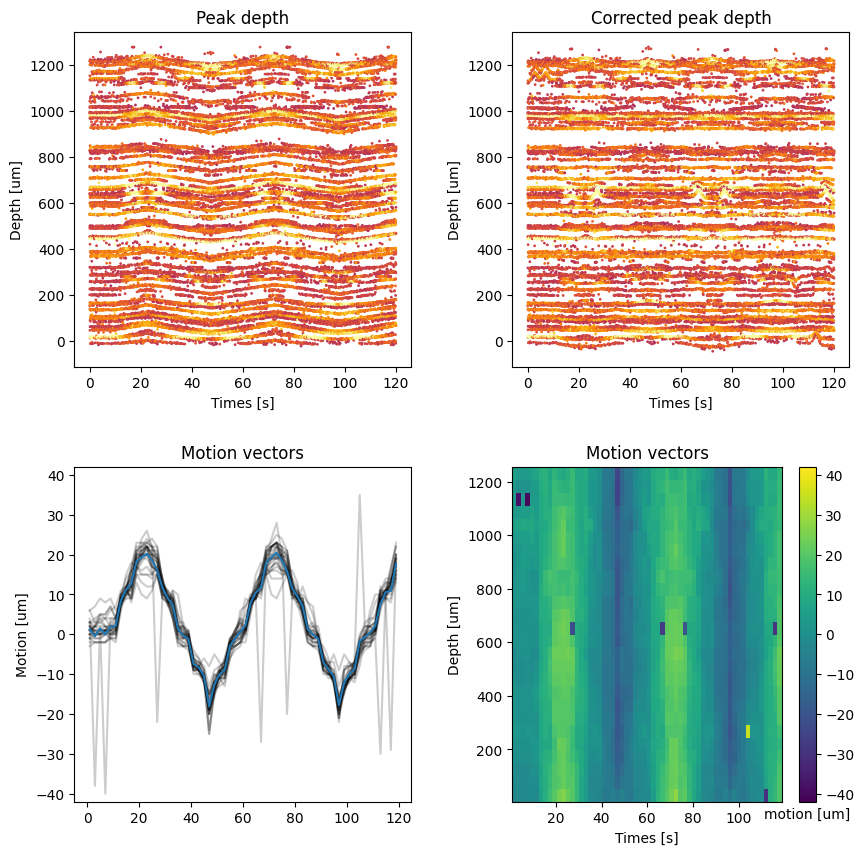

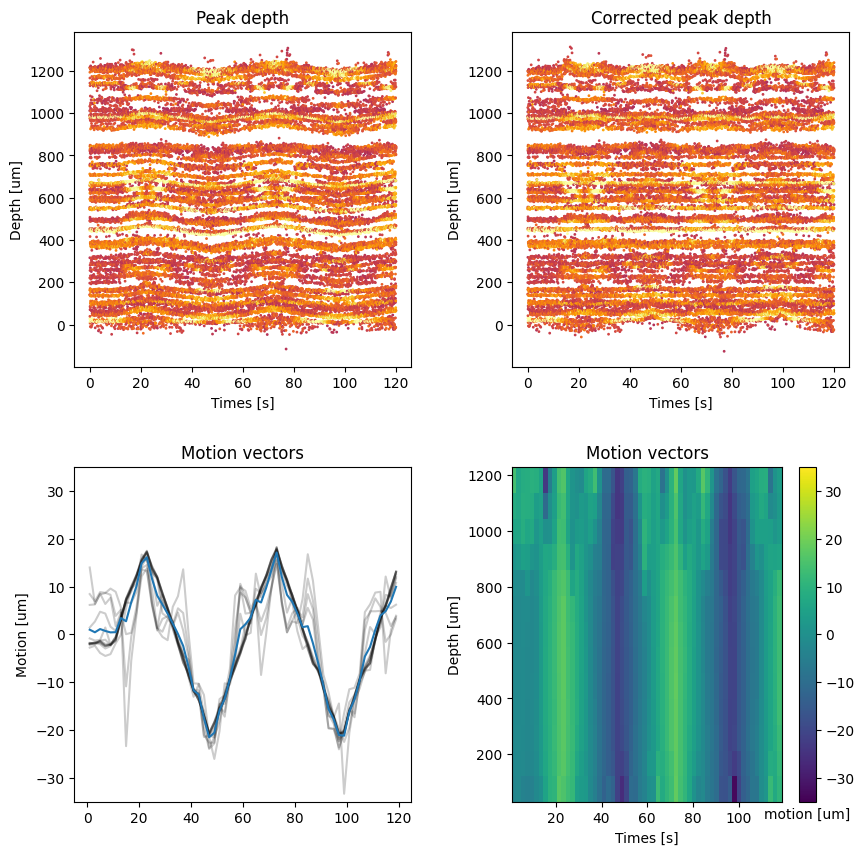

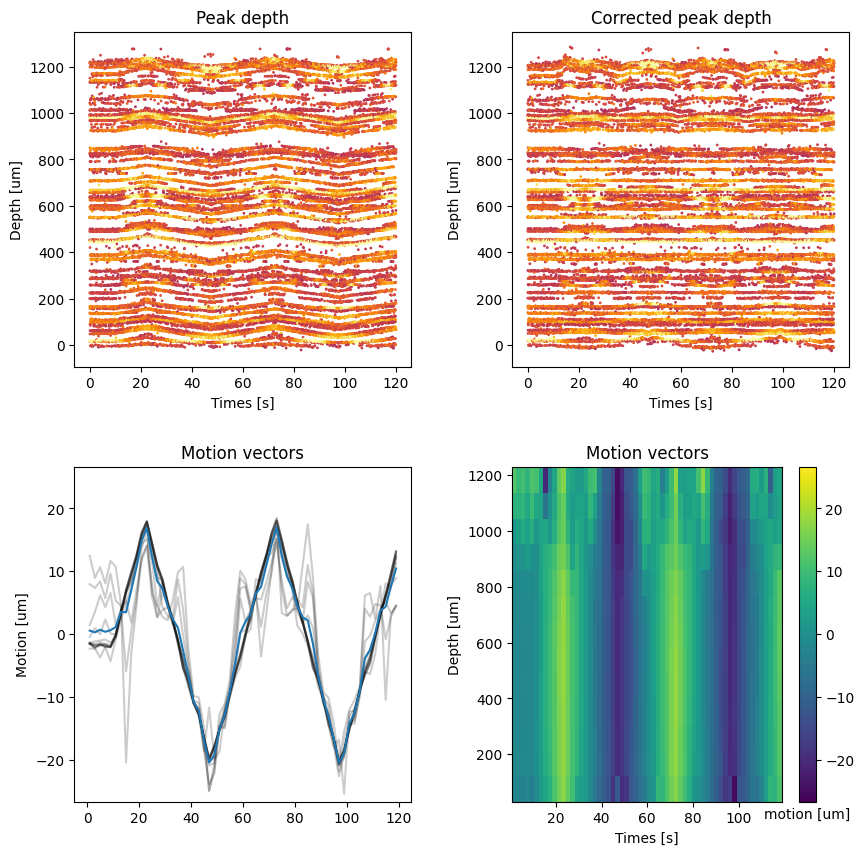

In [10]:
for method in ['kilosort_like', 'nonrigid_accurate', 'nonrigid_fast_and_accurate']:
    motion_info = si.load_motion_info(method)
    si.plot_motion(motion_info, 
                   motions_corrected[method], 
                   amplitude_cmap='inferno', 
                   color_amplitude=True, 
                   figsize=(10, 10))

In [11]:
method = 'nonrigid_fast_and_accurate'
motion_info = si.load_motion_info(method)
%matplotlib widget
si.plot_traces({'no correction' : drifting_preprocessed, 
                'correction' : motions_corrected[method]}, 
                backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Exercice

You can redo the same and estimate the motion in different cases:
- with abrupt, discontinuous drifts
- with non-rigid-drifts
- a combination of both!

In [12]:
zigzag_nonrigid = [{'drift_mode': 'zigzag', 
                       'non_rigid_gradient': 0.5, 
                       't_start_drift': 10.0, 
                       't_end_drift': None, 
                       'period_s': 50}]

rigid_bumps = [{'drift_mode': 'bump', 
                    'non_rigid_gradient': None, 
                    't_start_drift': 10.0, 
                    't_end_drift': None, 
                    'period_s': 50}]

combined_motions = zigzag_nonrigid + rigid_bumps

static, drifting, sorting = si.generate_drifting_recording(probe_name='Neuropixel-128', 
                                                    seed=23, 
                                                    duration=120, 
                                                    generate_displacement_vector_kwargs={'motion_list' : combined_motions})